In [38]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [39]:
from fastbook import *
import cv2

In [40]:
base_path='/content/gdrive/MyDrive/EmotionDetection/'

In [41]:
import zipfile
with zipfile.ZipFile(base_path+'archive.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/dataset')

In [42]:
Path.cwd().ls()

(#4) [Path('/content/.config'),Path('/content/dataset'),Path('/content/gdrive'),Path('/content/sample_data')]

In [44]:
from fastai.vision.all import *
path = Path('/content/dataset')

#  Data Block API
**a)** **DataBlock** is an object that is used in order to load the data into the model. You will notice that there is the "get_image_files" function in **DataBlock** which takes the path of the dataset and returns the path of each image in the dataset.

**b)** **RandomSplitter** is a function that splits data into training and validation datasets.

**c)** **RegexLabeller** is a class that allows you to use the path of an image in order to create labels. Since the folders are named with the emotion that they contain, I am able to use the folder names as labels for their images. You will see that there is a pattern I created, suitable to my labelling needs. This pattern indicates how the label's text should be according to the folder names.

Pattern = `.+/.+/(.+)/.+_\d+\.jpg$`

text i.e: Dataset/train/(happy)/Training_3908.jpg

The pattern is a Regular Expression. Let's see what "\d+\.jpg$" means. The "$" symbol means that the text ends at this point. The "\.jpg" indicates how the text should end because the names of the images end at ".jpg" as this is their type. The "\d+" means that the text at this point, should have one or more digits. That's the logic behind making the pattern you saw above.

You can refer for more about regular expressions (pattern) into this link: https://www.google.com/amp/s/www.geeksforgeeks.org/write-regular-expressions/amp/

**d)** **aug_transforms** produces more images by rotating, zooming etc the existing ones. The reason that we need this, is really simple. There is a possibility that if we give the network a rotated image, it won't predict it. A human can recognise-almost every time- an image that has seen before, when it is rotated or zoomed. That doesn't mean that a neural network is capable of doing the same thing.


In [45]:
emotions = DataBlock(blocks = (ImageBlock, CategoryBlock), 
                     get_items=get_image_files,
                     splitter=RandomSplitter(seed=42),
                     get_y=RegexLabeller(r'.+/.+/(.+)/.+_\d+\.jpg$'),
                     batch_tfms=aug_transforms(min_scale=0.75))
dls = emotions.dataloaders(path)
#RegexLabeller(how to create labels)

In [46]:
print(get_image_files(path))
#get_image_files function returns each image's path

[Path('/content/dataset/train/fear/Training_43723969.jpg'), Path('/content/dataset/train/fear/Training_88439684.jpg'), Path('/content/dataset/train/fear/Training_98348021.jpg'), Path('/content/dataset/train/fear/Training_54856669.jpg'), Path('/content/dataset/train/fear/Training_32296532.jpg'), Path('/content/dataset/train/fear/Training_92666544.jpg'), Path('/content/dataset/train/fear/Training_26073441.jpg'), Path('/content/dataset/train/fear/Training_94116429.jpg'), Path('/content/dataset/train/fear/Training_41514601.jpg'), Path('/content/dataset/train/fear/Training_63893915.jpg'), Path('/content/dataset/train/fear/Training_23628735.jpg'), Path('/content/dataset/train/fear/Training_62589694.jpg'), Path('/content/dataset/train/fear/Training_28589469.jpg'), Path('/content/dataset/train/fear/Training_21259247.jpg'), Path('/content/dataset/train/fear/Training_79159720.jpg'), Path('/content/dataset/train/fear/Training_52868666.jpg'), Path('/content/dataset/train/fear/Training_41096941.jpg

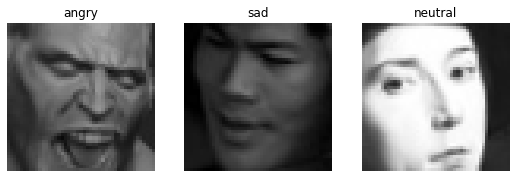

In [ ]:
dls.show_batch(nrows=1, ncols=3)
#Dataset Sample

#  Summary
By calling the summary, we can see the actual summary of the process before starting training the model.

**a)** First of all it would be helpful to explain what the Pilbase.create does since it wasn't so obvious for me either. Apparently the PILbase is a class that represents an image object. In order to create a new image it is needed for the factory function create to be used. So, what the PILbase.create does, is to actually take the path and then creates a new image.

**b)** Summary also calls the RegexLabeller which takes the path and gives a label as I described in DataBlock. (Data Block API *c)

**c)** Because neural networks work with numbers, it is also needed for the text label to be converted as an arithmetical one. So, the Summary calls the Categorize function which takes the text label and transforms it into an arithmetical one for the needs of the neural network.

**d)** The final sample contains all the images that are going to be used for training.

In [ ]:
emotions.summary(path)

Setting-up type transforms pipelines
Found 35887 items
2 datasets of sizes 28710,7177
Setting up Pipeline: PILBase.create
Setting up Pipeline: RegexLabeller -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /content/dataset/test/happy/PublicTest_41498575.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=48x48
  Pipeline: RegexLabeller -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /content/dataset/test/happy/PublicTest_41498575.jpg
    applying RegexLabeller gives
      happy
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(3)

Final sample: (PILImage mode=RGB size=48x48, TensorCategory(3))


Found 35887 items
2 datasets of sizes 28710,7177
Setting up Pipeline: PILBase.create
Setting up Pipeline: RegexLabeller -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
Setting up after_ite

# Training

 I have tried some ways of training but the results weren't so prosmising. So, I decided to use the last way of training that Fast ai suggests.

 This way of training freezes the model and trains it for some epochs and then unfreezes the model for many epochs. It also uses some default parameters chosen by the creators of Fast ai that turned out to be more efficient.

In [ ]:
learn = cnn_learner(dls, resnet50, metrics=error_rate).to_fp16()
learn.fine_tune(7, freeze_epochs=3)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


epoch,train_loss,valid_loss,error_rate,time
0,2.379162,1.962453,0.675213,01:00
1,1.762458,1.678981,0.641912,01:00
2,1.628968,1.578301,0.603595,01:02


epoch,train_loss,valid_loss,error_rate,time
0,1.451105,1.342425,0.506618,01:09
1,1.285890,1.193114,0.449213,01:09
2,1.179869,1.120224,0.418699,01:08
3,1.103522,1.066403,0.401143,01:07
4,1.007388,1.013588,0.375784,01:07
5,0.949126,1.009862,0.376480,01:08
6,0.877060,1.017219,0.373833,01:08


In [47]:
learn = load_learner ('/content/gdrive/MyDrive/newmodel.pkl')

# Confusion Matrix

The Confusion Matrix gives the visual results in terms of which labels are confused and how many predictions are confused with other actual emotions.

In order to read the Confusion Matrix correctly, you need to start from the top of the actual emotions (angry emotion) and then you need to continue diagonally to the bottom. If you do it this way, you will notice that each box of an actual emotion, applies to the predicted one and you will be able to see the correct predictions. For instance, the "angry" actual emotion has 544 correct predictions and all the others are confused with other actual emotions. The "disgust" actual emotion has 53 correct predictions and all the others are confused with other actual emotions etc.

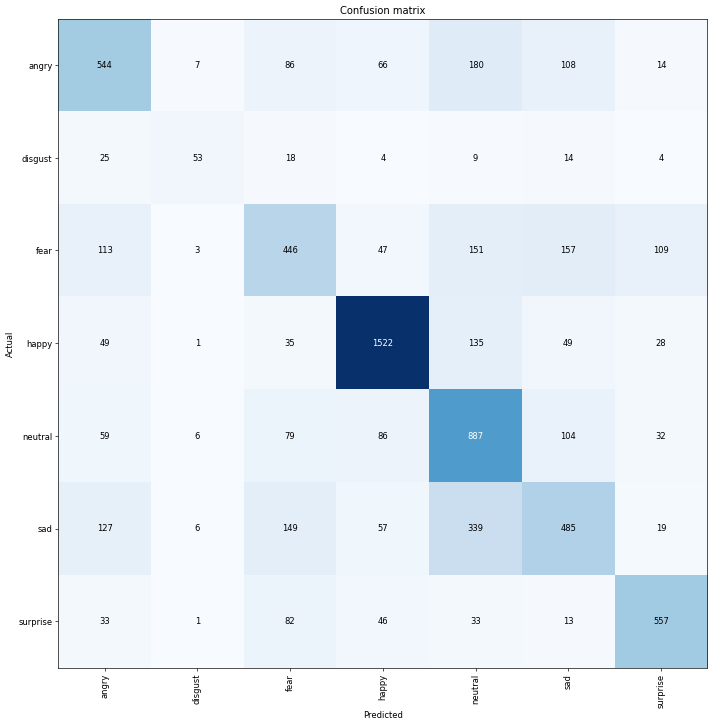

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [ ]:
interp.most_confused(min_val=5)

[('sad', 'neutral', 339),
 ('angry', 'neutral', 180),
 ('fear', 'sad', 157),
 ('fear', 'neutral', 151),
 ('sad', 'fear', 149),
 ('happy', 'neutral', 135),
 ('sad', 'angry', 127),
 ('fear', 'angry', 113),
 ('fear', 'surprise', 109),
 ('angry', 'sad', 108),
 ('neutral', 'sad', 104),
 ('angry', 'fear', 86),
 ('neutral', 'happy', 86),
 ('surprise', 'fear', 82),
 ('neutral', 'fear', 79),
 ('angry', 'happy', 66),
 ('neutral', 'angry', 59),
 ('sad', 'happy', 57),
 ('happy', 'angry', 49),
 ('happy', 'sad', 49),
 ('fear', 'happy', 47),
 ('surprise', 'happy', 46),
 ('happy', 'fear', 35),
 ('surprise', 'angry', 33),
 ('surprise', 'neutral', 33),
 ('neutral', 'surprise', 32),
 ('happy', 'surprise', 28),
 ('disgust', 'angry', 25),
 ('sad', 'surprise', 19),
 ('disgust', 'fear', 18),
 ('angry', 'surprise', 14),
 ('disgust', 'sad', 14),
 ('surprise', 'sad', 13),
 ('disgust', 'neutral', 9),
 ('angry', 'disgust', 7),
 ('neutral', 'disgust', 6),
 ('sad', 'disgust', 6)]

In [ ]:
learn.export('newmodel.pkl')

# OpenCV

 As I mentioned before, this project couldn't have been implemented without OpenCV. OpenCV is a library for computer vision. It offers another model that recognises faces. Since this project is connected to faces, I was searching for some kind of tool which could find the face in order to give some visual examples. 

This is the link of the guide I used and you can refer to. I created a simpler version of it: https://www.mygreatlearning.com/blog/real-time-face-detection/

Let's go through the process: 

a) The "imagePath" is the path to the images and "cascPath" is the path to a saved trained model -which is in an xml file form- that creates bounding boxes around the faces.

In [54]:
imagePath = base_path+'medium-shot-happy-man-smiling_23-2148221808.jpg'
cascPath = base_path+'haarcascade_frontalface_default.xml'

b) The "faceCascade" is the classifier that recognises faces.

In [55]:
faceCascade = cv2.CascadeClassifier(cascPath)

c) "cv2_imshow", shows the face and "image_grayscale" converts the images into greyscale. The reason that I chose to do that is because the Dataset contains images that are black and white and thus the predictions wouldn't be accurate at all if I didn't.

In [56]:
from google.colab.patches import cv2_imshow

image = cv2.imread(imagePath)
image_grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)



print(image[0][0])

[177 232 245]


d) At this point, I run the classifier in order to recognise the face. After that, I give the image that has a face, some parameters and the minimum size of the face square.

 The "face_squares" contains lists that define the face bounding boxes. I use images with only one face. In the "cv2.rectangle" you can put the coordinates that define the point where you want the bounding box to be drawn and you can also put the color of your preference for the bounding box. I wanted it to be blue so I chose 255, 0, 0.

e) The cropped image (image[y:y + h, x: x + w]) is now saved in the new_image. The "cv2_imshow(new_image)" shows the cropped image, transforms it into greyscale and then resizes it in order to do accurate classification.

It is important to mention that the model didn't work very well at first because of the size of the dataset's images and because of their color. The images of the dataset are black an white and small and the model would recognise an image that would be exactly like that. Now that I use this code for resizing and converting images into greyscale, the predictions are more accurate.

[[235  52 147 147]]


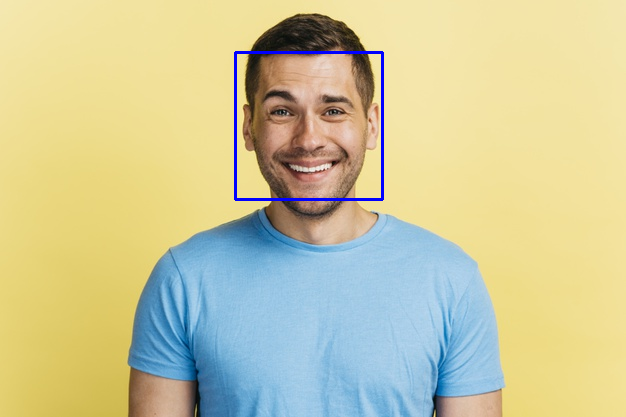

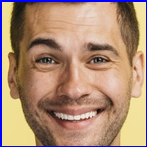

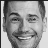

In [57]:
face_squares = faceCascade.detectMultiScale(image_grayscale,
    scaleFactor=1.2,
    minNeighbors=30,
    minSize=(100, 100)
    )

print(face_squares)


# Draw rectangle around the faces
(x,y,w,h) = face_squares[0]
cv2.rectangle(image, (x, y), (x+w, y+h), (255, 0, 0), 2)

new_image = image[y:y + h, x: x + w]
cv2_imshow(image)

# Display the output
from google.colab.patches import cv2_imshow

cv2_imshow(new_image)

new_image_gray=cv2.cvtColor(new_image, cv2.COLOR_BGR2GRAY)
resized = cv2.resize(new_image_gray, (48,48))


cv2_imshow(resized)


f) "learn.predict" gives the prediction of the image I gave.

In [58]:
emotion=learn.predict(resized)[0]
print (emotion)

happy


g) cv2.putText is creating the text on left corner of the bottom of the box(x,y+h) which indicates the prediction.

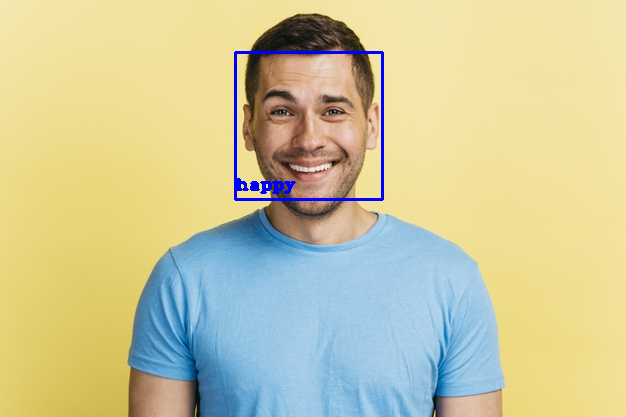

In [59]:

cv2.putText(image, emotion,(x,y+h-10),cv2.FONT_HERSHEY_COMPLEX_SMALL,0.8,(255, 0, 0), thickness=2 )
cv2_imshow(image)

In [ ]:
result =learn.predict(resized)
print(result[2])
print([str(percent * 100) + "%" for percent in result[2]])



tensor([0.0053, 0.0015, 0.0378, 0.0012, 0.0231, 0.0079, 0.9232])
['tensor(0.5290)%', 'tensor(0.1466)%', 'tensor(3.7846)%', 'tensor(0.1153)%', 'tensor(2.3136)%', 'tensor(0.7906)%', 'tensor(92.3204)%']
